# Population of X/Twitter users and web domains embedded in a multidimensional political opinion space

Author: Antoine Vendeville, Sciences Po médialab, Paris, France (2025)

Import packages.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import PercentFormatter
import numpy as np
from scipy.stats import binomtest
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from tqdm import tqdm

import os

Set options for plot formatting.

In [2]:
fontsize = 18
mpl.style.use('classic')
mpl.rcParams["figure.facecolor"] = 'white'
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = fontsize

Give each party a unique color.

In [3]:
party_color = {'DLF':'red', 'EELV':'limegreen', 'LFI':'darkviolet', 'LR':'navy', 'RE':'gold', 
                'MoDem':'orange', 'PCF':'firebrick', 'PS':'pink',
                'RN':'magenta', 'UDI':'grey'} 

Nicer names for political dimensions.

In [4]:
dim_names = {
	'lrecon':'Left - Right (economy)',
	'galtan':'Liberal - Conservative',
	'eu_position':'Anti EU - Pro EU',
	'antielite_salience':'Anti-elite sentiment',
	'lrgen':'Left - Right',
	'immigrate_policy':'Favors - Opposes (immigration)',
	'environment':'Favors - Opposes (environment over economy)',
	'sociallifestyle':'Favors - Opposes (liberal policies)',
	'nationalism':'Cosmopolitanism - Nationalism',
	'people_vs_elite':'Opposes - Favors (direct democracy)',
	'corrupt_salience':'Importance of reducing political corruption',
    'refugees':'Opposes - Favors (welcoming Ukrainian refugees)'
}

Paths.

In [ ]:
fig_path = 'plots/' # where should figures be saved
data_path = 'path_to_data_folder/' # where is the data with MPs and followers positions and annotations

Random seed for reproducibility.

In [6]:
SEED = 42

# Load data

In [7]:
os.makedirs(fig_path, exist_ok=True)

Positions of followers.

In [8]:
df_follower_positions = pd.read_csv(data_path + 'followers_positions.csv')

Look at the data.

In [9]:
df_follower_positions

,pseudo_id,lrecon_23,galtan_23,eu_position_23,antielite_salience_23,refugees_23,lrgen_19,lrecon_19,galtan_19,antielite_salience_19,corrupt_salience_19,people_vs_elite_19,immigrate_policy_19,eu_position_19,nationalism_19,environment_19,sociallifestyle_19
0,user_0,3.331,0.674,9.814,2.266,10.364,2.001,2.676,1.319,3.329,2.849,4.091,1.372,10.224,0.735,2.778,-0.366
1,user_1,5.383,6.459,3.246,7.364,5.050,6.927,5.538,6.064,7.831,4.853,5.115,7.343,4.054,6.862,5.538,5.490
2,user_2,5.591,5.647,4.673,6.438,6.574,5.893,5.061,5.445,7.595,4.547,4.901,6.865,5.027,5.883,5.813,4.691
3,user_3,6.023,8.610,1.732,9.007,5.583,10.147,6.900,8.253,10.101,6.092,8.938,10.303,1.674,9.952,7.621,7.752
4,user_4,4.672,4.069,6.031,5.178,7.390,4.093,3.888,4.339,5.616,3.732,4.250,4.640,6.358,4.291,4.601,3.195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978201,user_979084,4.030,5.654,1.814,8.606,5.443,4.506,3.460,5.682,9.147,5.053,5.462,6.561,2.635,5.904,5.264,4.488
978202,user_979085,6.334,8.621,1.344,8.392,3.498,9.161,7.394,8.044,7.497,4.811,4.496,9.227,3.087,9.106,6.657,8.276
978203,user_979086,2.917,4.895,1.821,7.959,6.129,4.521,3.656,4.821,7.417,4.665,5.363,5.330,4.390,5.076,4.285,3.698
978204,user_979087,5.199,6.614,2.199,8.474,4.584,5.836,4.457,6.424,9.278,5.177,5.329,7.587,2.305,6.998,5.793,5.529


Positions of MPs.

In [10]:
df_mp = pd.read_csv(data_path + 'mps_positions.csv')

In [11]:
df_mp

,pseudo_id,party,lrecon_23,galtan_23,eu_position_23,antielite_salience_23,refugees_23,lrgen_19,lrecon_19,galtan_19,antielite_salience_19,corrupt_salience_19,people_vs_elite_19,immigrate_policy_19,eu_position_19,nationalism_19,environment_19,sociallifestyle_19
0,user_2003,PCF,3.217,4.162,3.472,6.867,6.941,3.528,3.048,4.319,6.859,4.261,4.973,4.588,5.035,4.304,4.242,2.901
1,user_2340,UDI,6.918,5.431,7.599,3.356,8.682,6.346,6.714,5.263,3.632,2.861,2.604,6.231,8.859,5.171,6.475,5.209
2,user_2626,LFI,3.371,3.656,3.782,7.617,7.044,2.623,2.113,4.119,8.841,4.949,5.940,4.877,3.881,3.936,4.363,2.477
3,user_2652,LFI,2.637,2.683,4.427,6.896,7.794,2.148,1.934,3.313,7.473,4.558,5.777,3.682,5.286,2.998,3.602,1.620
4,user_3599,RN,5.918,8.932,0.540,9.301,3.157,9.758,7.103,8.437,8.879,5.421,6.113,9.759,1.578,9.841,6.757,8.351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,user_975106,NaN,5.601,4.080,6.892,4.994,8.865,5.771,5.196,5.242,5.743,3.029,2.864,6.723,6.980,5.873,7.700,3.451
879,user_976402,LC,6.476,5.405,7.067,3.569,8.466,6.171,6.519,5.158,3.442,2.901,2.701,5.895,8.798,5.096,6.085,5.065
880,user_976502,Independent,3.256,1.513,8.304,3.362,9.117,2.564,2.966,2.146,3.461,3.120,4.303,1.863,9.152,1.736,2.715,0.708
881,user_976811,LR,7.478,7.093,5.574,5.071,6.728,7.893,7.660,6.718,4.766,3.553,3.062,7.869,7.007,7.005,6.939,7.194


Annotations of followers (LLM).

In [12]:
df_follower_llm = pd.read_csv(data_path + 'followers_llm_annotations.csv')

In [13]:
df_follower_llm

,pseudo_id,right,left,populist,elite,eurosceptic,pro_european,liberal_immigration,restrictive_immigration,cosmopolitan,nationalist,pro_environment,climate_denialist,economic_focus,liberal,conservative
0,user_0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,1.0,0.0,0.0,NaN,0.0
1,user_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,user_4,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN
3,user_5,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0
4,user_6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521747,user_979080,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
521748,user_979082,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
521749,user_979083,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
521750,user_979085,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Annotations of followers (human).

In [14]:
df_follower_human = pd.read_csv(data_path + 'followers_human_annotations.csv')

In [15]:
df_follower_human

,pseudo_id,left,right,liberal_immigration,restrictive_immigration,eurosceptic,pro_european,populist,elite
0,user_210,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
1,user_260,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2,user_266,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
3,user_304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,user_687,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
5859,user_978312,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5860,user_978425,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
5861,user_978444,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN
5862,user_978631,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


Positions of media domains.

In [16]:
df_domains = pd.read_csv(data_path + 'domains_positions.csv')

In [17]:
df_domains

,domain,media_category,user_count,tweet_count,antielite_salience_23_mean,eu_position_23_mean,lrecon_23_mean,refugees_23_mean,galtan_23_mean,lrgen_19_mean,...,antielite_salience_23_pval,eu_position_23_pval,lrecon_23_pval,refugees_23_pval,galtan_23_pval,environment_19_pval,lrecon_19_pval,antielite_salience_19_pval,eu_position_19_pval,galtan_19_pval
0,lemonde.fr,Centre,21139,179198,5.745,5.319,4.860,7.162,4.646,5.201,...,0.000,0.003,0.085,0.993,0.451,0.742,0.000,0.090,0.993,0.045
1,lefigaro.fr,Hyper-centre,16205,153754,6.195,4.558,5.647,6.332,5.924,6.572,...,0.000,0.271,1.000,0.991,0.000,0.000,0.078,0.000,0.880,0.000
2,francetvinfo.fr,Hyper-centre,16195,136294,6.032,4.939,4.968,6.886,4.972,5.456,...,0.000,0.002,0.352,1.000,0.000,0.028,0.000,0.000,0.025,0.000
3,radiofrance.fr,NaN,11836,62895,5.644,5.463,4.765,7.314,4.459,4.985,...,0.000,0.050,0.001,0.992,0.999,1.000,0.000,0.599,0.990,0.992
4,liberation.fr,Centre,11509,71206,6.131,4.901,4.574,7.025,4.573,4.894,...,0.000,0.097,0.000,0.994,0.030,0.444,0.000,0.000,0.152,0.005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,jeune-nation.com,Identitarian,101,583,8.647,1.415,5.768,3.939,7.996,8.270,...,0.943,0.787,0.993,0.921,0.959,0.907,0.994,0.992,0.674,0.984
396,yetiblog.org,Right Wing,101,346,7.973,2.362,5.312,4.981,6.789,6.670,...,0.455,0.481,0.983,0.529,0.779,0.875,0.991,0.994,0.254,0.768
397,cointribune.com,NaN,100,611,6.610,4.041,5.729,5.972,6.278,6.712,...,0.561,0.305,0.907,0.961,0.603,0.657,0.992,0.511,0.227,0.753
398,attali.com,NaN,100,182,6.099,4.701,5.677,6.393,5.886,6.631,...,0.318,0.390,0.983,0.334,0.793,0.343,0.961,0.817,0.774,0.372


We merge the dataframes relating to followers for easier use.

In [18]:
# rename columns
df_follower_llm = df_follower_llm.rename(columns={c: 'LLM_'+c for c in df_follower_llm.columns if c!='pseudo_id'})
df_follower_human = df_follower_human.rename(columns={c: 'human_'+c for c in df_follower_human.columns if c!='pseudo_id'})

# merge
df_follower = df_follower_positions.merge(df_follower_llm, on='pseudo_id', how='left').merge(df_follower_human, on='pseudo_id', how='left')

In [19]:
df_follower

,pseudo_id,lrecon_23,galtan_23,eu_position_23,antielite_salience_23,refugees_23,lrgen_19,lrecon_19,galtan_19,antielite_salience_19,...,LLM_liberal,LLM_conservative,human_left,human_right,human_liberal_immigration,human_restrictive_immigration,human_eurosceptic,human_pro_european,human_populist,human_elite
0,user_0,3.331,0.674,9.814,2.266,10.364,2.001,2.676,1.319,3.329,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,user_1,5.383,6.459,3.246,7.364,5.050,6.927,5.538,6.064,7.831,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,user_2,5.591,5.647,4.673,6.438,6.574,5.893,5.061,5.445,7.595,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,user_3,6.023,8.610,1.732,9.007,5.583,10.147,6.900,8.253,10.101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,user_4,4.672,4.069,6.031,5.178,7.390,4.093,3.888,4.339,5.616,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978201,user_979084,4.030,5.654,1.814,8.606,5.443,4.506,3.460,5.682,9.147,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
978202,user_979085,6.334,8.621,1.344,8.392,3.498,9.161,7.394,8.044,7.497,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
978203,user_979086,2.917,4.895,1.821,7.959,6.129,4.521,3.656,4.821,7.417,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
978204,user_979087,5.199,6.614,2.199,8.474,4.584,5.836,4.457,6.424,9.278,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We discard the unmerged dataframes.

In [20]:
del df_follower_human, df_follower_llm, df_follower_positions

# General statistics
Code for Tables 1 and 7 of the article.

Show repartition of MPs in the different parties (Table 7 in the SI of the article).

In [21]:
df_mp['party'].value_counts(), ('NaN', df_mp['party'].isna().sum())

(party
 RE             193
 LR             172
 RN              87
 PS              84
 LFI             72
 MoDem           52
 Horizons        36
 UDI             33
 EELV            26
 PCF             25
 Independent     24
 PRV             14
 LC               7
 PRG              2
 DLF              1
 Name: count, dtype: int64,
 ('NaN', 55))

Gather statistics for Table 1 of the article.

In [22]:
data = {'Dimension':list(),
        'Description':list(),
        'Year':list(),
        'Mean':list(),
        'Std.':list(),
        '% outliers':list()}

In [23]:
df = pd.concat((df_mp, df_follower))
for c in df.columns:
    if '_19' in c or '_23' in c:

        # get stats
        name, year = c[:-3], '20'+c[-2:]
        percent_outliers = 100 * df[(df[c]<0) | (df[c]>10)].shape[0] / df.shape[0]

        # add to data
        data['Dimension'].append(name)
        data['Description'].append(dim_names[name])
        data['Year'].append(year)
        data['Mean'].append(df[c].mean())
        data['Std.'].append(df[c].std())
        data['% outliers'].append(percent_outliers)
del df

In [24]:
df_data = pd.DataFrame(data)

Round the floats.

In [25]:
df_data = df_data.round(3)

Show.

In [26]:
df_data

,Dimension,Description,Year,Mean,Std.,% outliers
0,lrecon,Left - Right (economy),2023,5.442,1.325,0.032
1,galtan,Liberal - Conservative,2023,6.001,1.906,0.200
2,eu_position,Anti EU - Pro EU,2023,3.972,2.320,5.597
3,antielite_salience,Anti-elite sentiment,2023,6.770,1.884,2.098
4,refugees,Opposes - Favors (welcoming Ukrainian refugees),2023,5.824,1.824,0.440
5,lrgen,Left - Right,2019,6.369,2.282,2.787
6,lrecon,Left - Right (economy),2019,5.430,1.963,0.050
7,galtan,Liberal - Conservative,2019,5.778,1.665,0.087
8,antielite_salience,Anti-elite sentiment,2019,7.103,1.860,4.084
9,corrupt_salience,Importance of reducing political corruption,2019,4.495,0.764,0.229


Export in latex format.

In [27]:
s = df_data.to_latex(float_format="%.3f", index=False)
print(s.replace('_','\_').replace('%','\%'))

\begin{tabular}{lllrrr}
\toprule
Dimension & Description & Year & Mean & Std. & \% outliers \\
\midrule
lrecon & Left - Right (economy) & 2023 & 5.442 & 1.325 & 0.032 \\
galtan & Liberal - Conservative & 2023 & 6.001 & 1.906 & 0.200 \\
eu\_position & Anti EU - Pro EU & 2023 & 3.972 & 2.320 & 5.597 \\
antielite\_salience & Anti-elite sentiment & 2023 & 6.770 & 1.884 & 2.098 \\
refugees & Opposes - Favors (welcoming Ukrainian refugees) & 2023 & 5.824 & 1.824 & 0.440 \\
lrgen & Left - Right & 2019 & 6.369 & 2.282 & 2.787 \\
lrecon & Left - Right (economy) & 2019 & 5.430 & 1.963 & 0.050 \\
galtan & Liberal - Conservative & 2019 & 5.778 & 1.665 & 0.087 \\
antielite\_salience & Anti-elite sentiment & 2019 & 7.103 & 1.860 & 4.084 \\
corrupt\_salience & Importance of reducing political corruption & 2019 & 4.495 & 0.764 & 0.229 \\
people\_vs\_elite & Opposes - Favors (direct democracy) & 2019 & 4.684 & 1.038 & 0.261 \\
immigrate\_policy & Favors - Opposes (immigration) & 2019 & 6.897 & 1.795 & 

<>:2: SyntaxWarning: invalid escape sequence '\_'
<>:2: SyntaxWarning: invalid escape sequence '\%'
<>:2: SyntaxWarning: invalid escape sequence '\_'
<>:2: SyntaxWarning: invalid escape sequence '\%'
/var/folders/ry/19z2xntn4jg3w86h2j05vvhw0000gn/T/ipykernel_12700/457657215.py:2: SyntaxWarning: invalid escape sequence '\_'
  print(s.replace('_','\_').replace('%','\%'))
/var/folders/ry/19z2xntn4jg3w86h2j05vvhw0000gn/T/ipykernel_12700/457657215.py:2: SyntaxWarning: invalid escape sequence '\%'
  print(s.replace('_','\_').replace('%','\%'))


# Usage notes
Code for bi-dimensional plot with MPs, followers and selected media domains (fig.5 in the article)

In [28]:
sns.set_theme(style="white", font='STIXGeneral', font_scale=1.5)

Dimensions: left-right and anti-elite.

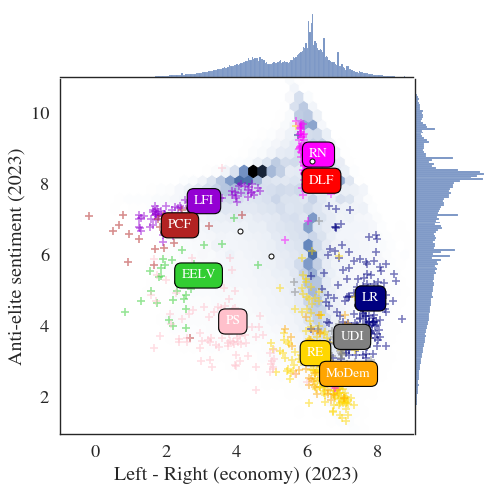

In [29]:
# Choose dimensions and domains to show.
xdim = 'lrecon_23' # x-axis
ydim = 'antielite_salience_23' # y-axis
domains = ('fdesouche.com', 'mediapart.fr', 'francetvinfo.fr') # media domains

# plot distribution of users
g = sns.jointplot(data=df_follower, x=xdim, y=ydim, kind='hex', gridsize=50)
ax = g.ax_joint

# plot positions of MPs party by party
for party,color in party_color.items():

        # plot positions
        ax.scatter(df_mp[df_mp['party']==party][xdim],
                df_mp[df_mp['party']==party][ydim],
                s=40,alpha=0.5,marker='+',c=color)
        
        # party centres
        x = df_mp[df_mp['party']==party][xdim].mean()
        y = df_mp[df_mp['party']==party][ydim].mean()
        ax.plot(x,y,color=color,marker='o',markeredgecolor='k',markersize=7)

        # annotate
        xbox, ybox = x+.1, y+.1
        if party=='DLF':
                ybox = y-.3
        if party=='RE':
                xbox = x-.4
        if party=='MoDem':
                ybox = y-.3
        ax.text(xbox, ybox, party, color='white', fontsize=12,
                bbox=dict(facecolor=color, edgecolor='black', boxstyle='round,pad=0.5'))
        
# add media domains
color = 'w'
for d in domains:

        # plot
        x = df_domains[df_domains['domain']==d][xdim+'_mean']
        y = df_domains[df_domains['domain']==d][ydim+'_mean']
        ax.scatter(x, y, color=color, marker="o", edgecolor='k', facecolor='w', s=20, zorder=20)

# style
ax.set_xlabel(f'{dim_names[xdim[:-3]]} (20{xdim[-2:]})')
ax.set_ylabel(f'{dim_names[ydim[:-3]]} (20{ydim[-2:]})')
ax.set_xlim(-1,9)
ax.set_ylim(1,11)

# save and show
plt.tight_layout(pad=.1)
plt.savefig(fig_path + f'2D_plot_{xdim}_{ydim}.png', dpi=300)
plt.show()
plt.close()

Dimensions: immigration and EU.

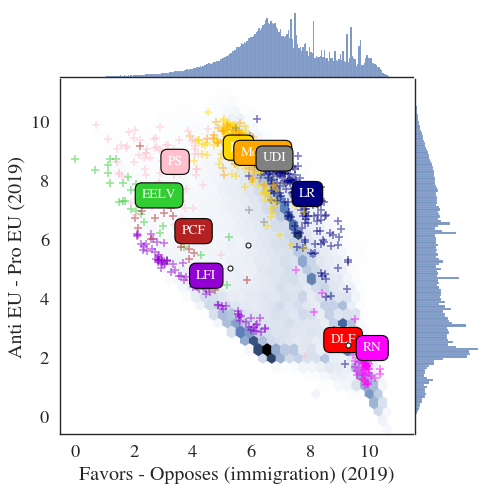

In [30]:
# select dimensions and domains to show
xdim = 'immigrate_policy_19'
ydim = 'eu_position_19'
domains = ('fdesouche.com', 'mediapart.fr', 'francetvinfo.fr')

# plot distribution of users
g = sns.jointplot(data=df_follower, x=xdim, y=ydim, kind='hex', gridsize=50)#, cmap='Greys')
ax = g.ax_joint

# plot positions of MPs party by party
for party,color in party_color.items():

        # plot positions
        ax.scatter(df_mp[df_mp['party']==party][xdim],
                df_mp[df_mp['party']==party][ydim],
                s=40,alpha=0.5,marker='+',c=color)
        
        # party centres
        x = df_mp[df_mp['party']==party][xdim].mean()
        y = df_mp[df_mp['party']==party][ydim].mean()
        ax.plot(x,y,color=color,marker='o',markeredgecolor='k',markersize=7)

        # annotate
        xbox, ybox = x+.1, y+.1
        if party=='DLF':
                ybox = y-.3
        if party=='RE':
                xbox = x-.4
        if party=='MoDem':
                ybox = y-.3
        ax.text(xbox, ybox, party, color='white', fontsize=12,
                bbox=dict(facecolor=color, edgecolor='black', boxstyle='round,pad=0.5'))
        
# add media domains
color = 'w'
for d in domains:

        # plot
        x = df_domains[df_domains['domain']==d][xdim+'_mean']
        y = df_domains[df_domains['domain']==d][ydim+'_mean']
        ax.scatter(x, y, color=color, marker="o", edgecolor='k', facecolor='w', s=20, zorder=20)

# style
ax.set_xlabel(f'{dim_names[xdim[:-3]]} (20{xdim[-2:]})')
ax.set_ylabel(f'{dim_names[ydim[:-3]]} (20{ydim[-2:]})')
ax.set_xlim(-.5,11.5)
ax.set_ylim(-.5,11.5)

# save and show
plt.tight_layout(pad=.1)
plt.savefig(fig_path + f'2D_plot_{xdim}_{ydim}.png', dpi=300)
plt.show()
plt.close()

# Technical validation

Code used for the technical validation. Output: figures 1,2,3,4 and Tables 6,8 of the article.

## Validating consistency for dimensions present in the 2019 and 2023 CHES waves
This is the code used to create Figure 3. Requires the CHES data from 2019 and 2023, to download from https://www.chesdata.eu/ches-europe (2023 SPEED CHES - Ukraine and 2019 Chapel Hill expert survey).

Load CHES dataframes.

In [31]:
ches_path = '../CHES data/' # where are the CHES files (to download from https://www.chesdata.eu/)
df_ches_2019 = pd.read_csv(ches_path + 'CHES2019V3.csv')
df_ches_2023 = pd.read_csv(ches_path + 'CHES_Ukraine_March_2024.csv')

Discard irrelevant CHES rows.

In [32]:
df_ches_2019 = df_ches_2019[df_ches_2019.country==6]
df_ches_2023 = df_ches_2023[df_ches_2023.country=='France']

Harmonize the party names.

In [33]:
party_matching = {'FI':'LFI', 'REM; RE':'RE', 'LREM':'RE'}
df_ches_2019 = df_ches_2019.replace(party_matching)
df_ches_2023 = df_ches_2023.replace(party_matching)

Remember parties that are in both CHES dataframes.

In [34]:
ches_parties = set(df_ches_2019.party).intersection(set(df_ches_2023.party))

In [35]:
df_ches_2019

,country,eastwest,party,party_id,eu_position,eu_position_sd,eu_salience,eu_dissent,eu_blur,eu_cohesion,...,regions,russian_interference,anti_islam_rhetoric,people_vs_elite,antielite_salience,corrupt_salience,members_vs_leadership,eu_econ_require,eu_political_require,eu_googov_require
51,6,1.0,PCF,601,3.000000,1.069045,4.625000,3.666667,4.000000,4.800000,...,4.833334,1.500000,2.000000,4.125000,6.857143,2.857143,5.000000,NaN,NaN,NaN
52,6,1.0,PS,602,6.125000,0.640870,6.375000,5.333334,4.250000,6.200000,...,3.500000,3.333333,2.285714,4.125000,3.857143,3.285714,5.250000,NaN,NaN,NaN
53,6,1.0,EELV,605,6.375000,0.744024,6.875000,3.666667,1.750000,6.000000,...,2.666667,3.166667,1.571428,5.750000,4.285714,4.142857,3.500000,NaN,NaN,NaN
54,6,1.0,LR,609,5.500000,0.925820,6.000000,6.666666,4.000000,5.400000,...,5.000000,2.666667,6.500000,2.285714,3.714286,3.000000,7.375000,NaN,NaN,NaN
55,6,1.0,RN,610,1.375000,0.517549,8.625000,2.666667,2.500000,2.000000,...,4.600000,2.333333,9.500000,7.750000,9.428572,5.714286,9.500000,NaN,NaN,NaN
56,6,1.0,MoDem,613,6.714286,0.487950,7.125000,2.666667,2.666667,5.400000,...,4.200000,3.000000,2.285714,3.375000,3.666667,3.571429,6.428571,NaN,NaN,NaN
57,6,1.0,RE,626,6.833334,0.408248,8.833333,3.000000,1.000000,6.666666,...,4.750000,4.750000,3.200000,3.333333,5.000000,2.833333,9.333333,NaN,NaN,NaN
58,6,1.0,LFI,627,2.875000,1.125992,6.875000,6.500000,4.750000,3.833333,...,5.200000,2.500000,1.833333,7.000000,9.571428,5.714286,7.750000,NaN,NaN,NaN
59,6,1.0,DLF,628,1.428572,0.534522,8.428572,1.333333,2.500000,2.333333,...,5.500000,1.400000,9.200000,4.750000,8.200000,5.200000,8.750000,NaN,NaN,NaN


Repeated dimensions.

In [36]:
Dimensions = [('lrecon_19','lrecon_23'),
              ('eu_position_19','eu_position_23'),
              ('galtan_19','galtan_23'),
              ('antielite_salience_19','antielite_salience_23')]

Rescale EU dimensions to the range 0-10 to match our data.

In [37]:
df_ches_2019['eu_position'] = (df_ches_2019['eu_position'].astype(float) * (5/3)) - (5/3)
df_ches_2023['eu_position'] = (df_ches_2023['eu_position'].astype(float) * (5/3)) - (5/3)

In [38]:
df_ches_2023

,country,party_id,party,family,electionyear,vote,seats,seatperc,govt,refugees,...,energy_costs,UA_EU,Kremlin_ties,EU_Russia,lrecon,galtan,eu_position,antielite_salience,in_gov,supportUA
51,France,601,PCF,rad left,2022,2.17,12.0,2.08,0.0,8.40000,...,3.83333,5.00000,5.83333,5.00000,2.00000,3.16667,3.333333,6.50000,Opposition Parties,-0.665416
52,France,602,PS,socialist,2022,5.06,28.0,4.85,0.0,9.33333,...,6.33333,7.00000,8.00000,3.33333,3.50000,2.16667,7.500000,4.00000,Opposition Parties,0.348705
53,France,603,PRG,socialist,2022,3.70,22.0,3.81,0.0,9.00000,...,5.75000,6.75000,6.75000,4.50000,4.20000,3.60000,6.333333,4.00000,Opposition Parties,-0.023726
54,France,605,EELV,green,2022,5.60,31.0,5.37,0.0,8.83333,...,7.00000,7.16667,8.16667,3.00000,2.50000,1.33333,7.222217,4.33333,Opposition Parties,0.449898
55,France,609,LR,cons,2022,10.76,61.0,10.57,0.0,7.16667,...,5.00000,4.66667,5.83333,5.33333,8.16667,7.83333,5.555550,4.66667,Opposition Parties,-0.548888
56,France,610,RN,TAN,2022,18.68,89.0,15.42,0.0,5.00000,...,2.33333,3.00000,3.66667,6.50000,6.00000,8.50000,1.666667,8.83333,Opposition Parties,-1.552151
57,France,613,MoDem,liberal,2022,5.05,48.0,8.32,0.0,9.00000,...,7.80000,7.60000,8.20000,3.60000,6.66667,4.16667,9.444450,2.50000,Opposition Parties,0.575141
58,France,626,RE,liberal,2022,20.71,197.0,34.14,1.0,9.33333,...,8.16667,7.00000,8.00000,4.00000,6.83333,4.33333,9.444450,2.33333,Government Parties,0.557877
59,France,627,LFI,rad left,2022,12.83,71.0,12.31,0.0,7.66667,...,4.00000,4.16667,4.66667,5.66667,1.80000,2.16667,3.055550,8.66667,Opposition Parties,-0.945855
60,France,628,DLF,TAN,2022,1.10,1.0,0.17,0.0,2.60000,...,1.80000,2.40000,3.00000,6.40000,6.00000,8.66667,0.555550,9.16667,Opposition Parties,-1.854339


Scatter plot and compute correlation. We only show the legend in the first subplot.

/Users/pedroramaciotti/WorkFiles/genericenv/lib/python3.12/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


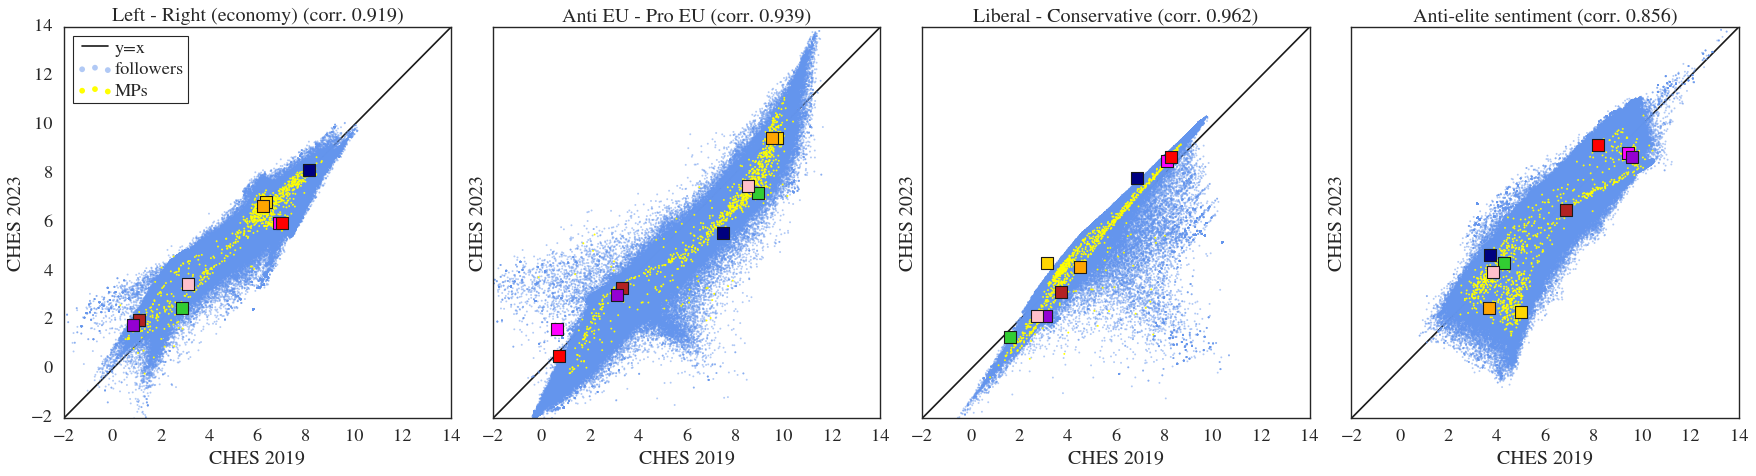

In [39]:
fig, axes = plt.subplots(1,4,figsize=(22,6), sharex=True, sharey=True)
df_ = pd.concat((df_mp,df_follower)) # create dataframe with both mps and users to compute correlation

for i,(d1,d2) in enumerate(Dimensions):

    # initialize
    ax = axes[i]
    handles, handles_ = list(), list() # for legend

    # compute correlation
    values1 = df_[d1]
    values2 = df_[d2]
    correlation = values1.corr(values2)

    # draw identity line
    mini = -2
    maxi = 14
    plot, = ax.plot([mini, maxi], [mini, maxi], c='k', label='y=x', zorder=-10)
    if i==0: # for legend
        handles.append(plot)

    # scatter plot follwoers
    x_values, y_values = df_follower[d1], df_follower[d2]
    scatter = ax.scatter(x_values, y_values, alpha=.5, s=3, facecolor='cornflowerblue', edgecolor='none',  label='followers')
    if i==0: # for legend
        handles.append(scatter)

    # scatter plot MPs
    x_values, y_values = df_mp[d1], df_mp[d2]
    scatter = ax.scatter(x_values, y_values, s=3, facecolor='yellow', edgecolor='none', label='MPs')
    if i==0: # for legend
        handles.append(scatter)

    # plot CHES party values
    for p in ches_parties:
        x = df_ches_2019[df_ches_2019.party==p][d1[:-3]]
        y = df_ches_2023[df_ches_2023.party==p][d2[:-3]]
        col = party_color[p] 
        ax.scatter([x], [y], marker='s', s=100, facecolor=col, linewidths=1, edgecolor='k', zorder=10)
        handles_.append(plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=col, markeredgecolor='k', markersize=8, label=p)) # for custom legend below

    
    # legend
    if i==0:
        ax.legend(handles=handles, loc='upper left', markerscale=3,
                  labelspacing=.25, handletextpad=.1, columnspacing=.5, borderpad=.2)
    
    # formatting
    ax.set_xlim(mini, maxi)
    ax.set_ylim(mini, maxi)
    ax.set_xlabel('CHES 2019')
    ax.set_ylabel('CHES 2023')
    ax.set_title(f'{dim_names[d1[:-3]]} (corr. {correlation:.3f})')

# save and show
plt.tight_layout(pad=.5)
plt.savefig(fig_path + '2019_vs_2023.png',dpi=300)
plt.show()
plt.close()
del df_

Create custom legend for CHES parties.

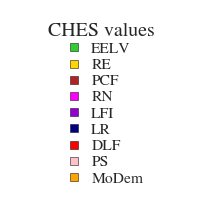

In [40]:
plt.figure(figsize=(3,3))
plt.legend(handles=handles_, loc='center', frameon=False, title='CHES values', ncols=1, fontsize=14, numpoints=1, markerscale=1, labelspacing=.15, handletextpad=.1, columnspacing=.5, borderpad=.2)
plt.axis('off')
plt.savefig(fig_path+'legend_2019vs2023.png', dpi=300)
plt.show()
plt.close()

## Validating users positions
This is the code used for Tables 6, 8, and figs 1, 2.

### Initialize

List of CHES dimensions and corresponding labels.

In [41]:
dimensions_and_labels = (
    ('LLM_left','LLM_right','lrgen_19'),
    ('LLM_populist','LLM_elite','antielite_salience_19'),
    ('LLM_populist','LLM_elite','corrupt_salience_19'),
    ('LLM_eurosceptic','LLM_pro_european','eu_position_19'),
    ('LLM_left','LLM_right','lrecon_19'),
    ('LLM_populist','LLM_elite','people_vs_elite_19'),
    ('LLM_liberal_immigration','LLM_restrictive_immigration','immigrate_policy_19'),
    ('LLM_liberal','LLM_conservative','galtan_19'),
    ('LLM_liberal','LLM_conservative','sociallifestyle_19'),
    ('LLM_cosmopolitan','LLM_nationalist','nationalism_19'),
    ('LLM_pro_environment','LLM_climate_denialist','environment_19'),
    ('LLM_pro_environment','LLM_economic_focus','environment_19'),
    ('LLM_populist','LLM_elite','antielite_salience_23'),
    ('LLM_eurosceptic','LLM_pro_european','eu_position_23'),
    ('LLM_left','LLM_right','lrecon_23'),
    ('LLM_liberal_immigration','LLM_restrictive_immigration','refugees_23'),
    ('LLM_liberal','LLM_conservative','galtan_23'),
    ('human_left','human_right','lrgen_19'),
    ('human_left','human_right','lrecon_19'),
    ('human_left','human_right','lrecon_23'),
    ('human_populist','human_elite','antielite_salience_19'),
    ('human_populist','human_elite','corrupt_salience_19'),
    ('human_populist','human_elite','people_vs_elite_19'),
    ('human_populist','human_elite','antielite_salience_23'),
    ('human_eurosceptic','human_pro_european','eu_position_19'),
    ('human_eurosceptic','human_pro_european','eu_position_23'),
    ('human_liberal_immigration','human_restrictive_immigration','immigrate_policy_19'),
    ('human_liberal_immigration','human_restrictive_immigration','refugees_23')
)

Find min and max values for each CHES dimension. Set limits for bins.

In [42]:
dimensions = [dim[-1] for dim in dimensions_and_labels]
dimension_min = {dim:0 for dim in dimensions}
dimension_max = {dim:10 for dim in dimensions}
dimension_bins = {d:10 for d in dimensions}

For labels replace nans with zeros.

In [43]:
for c in df_follower.columns:
    if c.startswith('human_') or c.startswith('LLM_'):
        df_follower[c] = df_follower[c].fillna(0)

### Functions

To get label names and annotator from column name.

In [44]:
def get_name_annotator(label_name):
    if label_name.startswith('LLM_'):
        name, annotator = label_name[4:], label_name[:3]
    else:
        name, annotator = label_name[6:], label_name[:5]
    return name, annotator

Function to draw bin plots (used to generate fig.1)

In [45]:
def bin_plot(dim, label, confidence=True, color='k', marker='s',
             save=False, show=True):
    """
    dim: political dimension (eg lrecon_23)
    label: label of interest (eg left)
    confidence: draw Clopper-Pearson confidence intervals?
    save: save the figure?
    show: show the figure?
    """
    
    fig,ax = plt.subplots()

    # initialize
    xaxis_min = dimension_min[dim]
    xaxis_max = dimension_max[dim]
    n_bins = dimension_bins[dim]
    bin_borders = np.linspace(xaxis_min, xaxis_max, n_bins+1)
    background_color = ('lightgrey','darkgrey')
    
    # compute
    prop_ones = list()
    ci_low = list()
    ci_high = list()
    N_list = list()
    ones_list = list()

    for i in range(n_bins):

        # get bin borders
        mini, maxi = bin_borders[i], bin_borders[i+1]

        # restrict to bin borders
        df = df_follower[[dim, label]]
        df = df[(df[dim]>=mini) & (df[dim]<=maxi)] 
        
        # separate llm labels
        df0 = df.loc[df[label]!=1]
        df1 = df.loc[df[label]==1]

        # count zeros and ones
        zeros = df0.shape[0]
        ones = df1.shape[0]
        N = ones+zeros
        ones_list.append(ones)

        # compute proportion of ones
        if N>0:
            prop = ones/N
            prop_ones.append(prop)
            ci = binomtest(k=ones,n=N).proportion_ci()
            ci_low.append(ci.low)
            ci_high.append(ci.high)
            N_list.append(N)
        else:
            prop_ones.append(np.nan)
            ci_low.append(np.nan)
            ci_high.append(np.nan)
            N_list.append(np.nan)

    # plot
    xrange = [np.mean(bin_borders[i:i+2]) for i in range(n_bins)]    
    yerr = np.array([ci_low,ci_high]) if confidence else 0
    plt.errorbar(xrange, prop_ones, yerr, fmt=marker, markersize=9, capsize=0, color=color)

    # fill background
    for i in range(n_bins):
        mini,maxi = bin_borders[i],bin_borders[i+1]
        plt.axvspan(xmin=mini, xmax=maxi, facecolor=background_color[i%2], lw=0, ls=':', alpha=.35)

    # format
    plt.xticks(bin_borders)
    plt.xlabel(f'{dim_names[dim[:-3]]} (20{dim[-2:]})')
    name, annotator = get_name_annotator(label)
    plt.ylabel(f'% users annotated {name} ({annotator})')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))

    # save and show
    plt.tight_layout()
    if save:
        plt.savefig(fig_path + f'bins_{dim}_{label}.png')
    if show:
        plt.show()
    plt.close()

Perform and plot logistic regression (used to generate fig. 2, Table 6 and Table 8).
- Draws the figure.
- Returns goodness of fit metrics.

In [46]:
def logreg(dim, labelA, labelB,
           color0='navy', color1='crimson', color2='grey', color3='k',
           save=False, show=True, verbose=False):
    """
    dim: political dimension (eg lrecon_23)
    labelA: label of interest, treated as success (eg left)
    labelB: label of interest, treated as failure (eg left)
    color0, color1, color2: colors of each label, for the logistic curve and for the cutoff line
    save: save the figure?
    show: show the figure?
    verbose: print information?
    """
    
    # initiate
    df = df_follower[[dim, labelA, labelB]]
    df = df.loc[((df[labelA]==0) & (df[labelB]==1)) | ((df[labelA]==1) & (df[labelB]==0))]
    df_neg = df[df[labelB]==1]
    df_pos = df[df[labelA]==1]  
    size_neg = df_neg.shape[0]
    size_pos = df_pos.shape[0]
    if verbose:
        print(f"N samples positive : {size_pos}")
        print(f"N samples negative : {size_neg}")

    # concatenate values
    x = np.concatenate((df_neg[dim].values, df_pos[dim].values)).reshape(-1,1)
    y = np.concatenate((df_neg[labelA].values, df_pos[labelA].values))

    # perform logreg
    logreg = LogisticRegression(class_weight='balanced')
    logreg.fit(x, y)

    # compute scores
    y_pred = logreg.predict(x)
    y_probs = logreg.predict_proba(x)[:, 1]
    ROC_AUC = metrics.roc_auc_score(y, y_probs)
    F1 = metrics.f1_score(y, y_pred)
    Precision = metrics.precision_score(y, y_pred)
    Recall = metrics.recall_score(y, y_pred)
    if verbose:
        print(f'ROC_AUC {ROC_AUC:.3f}, F1 {F1:.3f}, Precision {Precision:.3f}, Recall {Recall:.3f}')

    # get decision boundary
    coef = logreg.coef_[0][0]  # The coefficient (w)
    intercept = logreg.intercept_[0]  # The intercept (b)
    x_boundary = -intercept/coef # where predict_proba = 0.5 (decision boundary)

    # get class names
    name_positive, annotator_positive = get_name_annotator(labelA)
    name_negative, annotator_negative = get_name_annotator(labelB)

    # plot distributions
    fig,ax = plt.subplots()
    sns.kdeplot(df_pos[dim], color=color1, fill=True, alpha=.1, lw=2, label=f'Label "{name_positive}" ({annotator_positive})')
    sns.kdeplot(df_neg[dim], color=color0, fill=True, alpha=.1, lw=2, label=f'Label "{name_negative}" ({annotator_negative})')

    # plot logistic function
    xrange = np.linspace(df[dim].min(),df[dim].max(),100).reshape(-1,1)
    y_probs_range = logreg.predict_proba(xrange)[:, 1]
    ax.plot(xrange, y_probs_range, label='Logistic curve', lw=2, color=color2)
    ax.axhline(.5, ls='--', color=color3)
    ax.axvline(x_boundary, ls='--', color=color3, label="Cutoff")
    plt.xlabel(f'{dim_names[dim[:-3]]} (20{dim[-2:]})')
    
    # formatting
    plt.ylabel(f'Density')# of {dim}')
    loc = 'upper right' if intercept>0 else 'upper left'
    plt.legend(loc=loc, facecolor='whitesmoke', fontsize=fontsize-2, borderpad=.2, labelspacing=.2)
    plt.title(f'ROC AUC {ROC_AUC:.3f}, F1-score {F1:.3f}')

    # save and show
    plt.tight_layout()
    if save:
        plt.savefig(fig_path + f'logreg_{dim}_{labelA}_{labelB}.png')
    if show:
        plt.show()
    plt.close()

    return ROC_AUC, F1, Precision, Recall , size_neg, size_pos

### Example

Choose dimension and annotations classes.

In [47]:
dim = 'lrecon_19'
labelA = 'human_left'
labelB = 'human_right'

Bin plot.

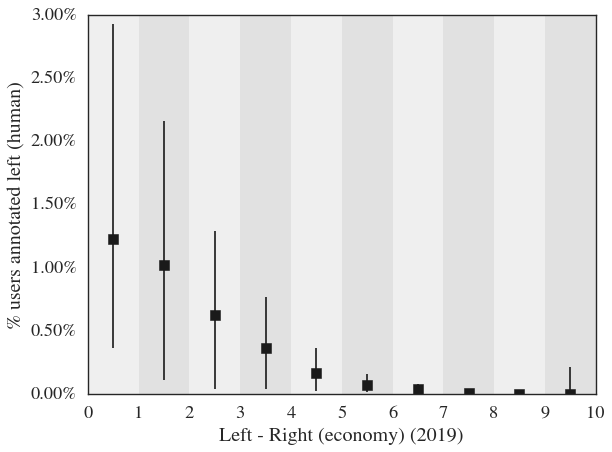

In [48]:
bin_plot(dim, labelA, confidence=True, color='k', marker='s', save=False, show=True)

Logistic regression.

N samples positive : 1975
N samples negative : 1593
ROC_AUC 0.991, F1 0.955, Precision 0.972, Recall 0.938


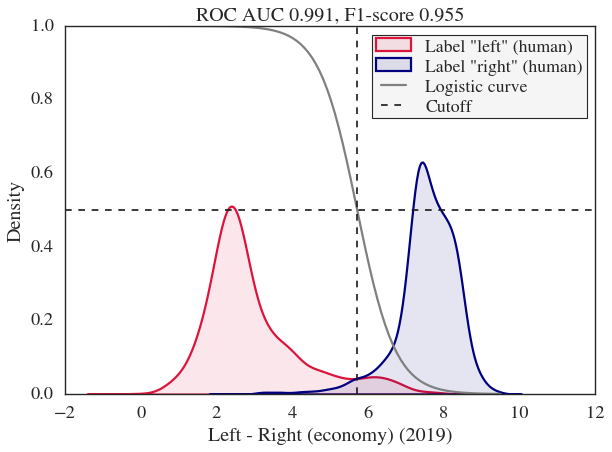

In [49]:
ROC_AUC, F1, Precision, Recall , size_neg, size_pos = logreg(dim, labelA, labelB, 
       color0='navy', color1='crimson', color2='grey', color3='k',
       save=False, show=True, verbose=True)

Show goodness of fit metrics.

In [50]:
print(ROC_AUC, F1, Precision, Recall , size_neg, size_pos)

0.9909658553640532 0.954639175257732 0.9721784776902888 0.9377215189873418 1593 1975


### Systematic computation

Perform validation for all tuples of dimensions and labels (in both orders because logistic regression is not symmetrical w.r.t. order of classes). Show plots, save plots, and register logistic regression scores in a table.

We create Tables 6 and 8 of the article here.

In [51]:
data = {'Dimension':list(),
        'Label A':list(),
        'Label B':list(),
        'N_A':list(),
        'N_B':list(),
        'ROC AUC':list(),
        'F1':list(),
        'Precision':list(),
        'Recall':list()}

In [52]:
for labelA, labelB, dim in tqdm(dimensions_and_labels):

    # do both possible orders for class
    for labelA, labelB  in ((labelA,labelB), (labelB,labelA)): 

        # bin plot
        bin_plot(dim, labelA, confidence=True, color='k', marker='s', save=True, show=False)
        
        # log reg
        ROC_AUC, F1, Precision, Recall, size_neg, size_pos = logreg(dim, labelA, labelB, save=True, show=False, verbose=False)
        
        # save result
        data['Dimension'].append(dim)
        data['Label A'].append(labelA)
        data['Label B'].append(labelB)
        data['N_A'].append(size_pos)
        data['N_B'].append(size_neg)
        data['ROC AUC'].append(ROC_AUC)
        data['F1'].append(F1)
        data['Precision'].append(Precision)
        data['Recall'].append(Recall)

100%|██████████| 28/28 [00:18<00:00,  1.54it/s]


#### Create a nice result table

Create dataframe from results.

In [53]:
df_scores = pd.DataFrame(data)
df_scores = df_scores.sort_values(by='ROC AUC', ascending=False)

In [54]:
df_scores

,Dimension,Label A,Label B,N_A,N_B,ROC AUC,F1,Precision,Recall
35,lrgen_19,human_right,human_left,1593,1975,0.991468,0.955501,0.940962,0.970496
34,lrgen_19,human_left,human_right,1975,1593,0.991468,0.963077,0.975584,0.950886
36,lrecon_19,human_left,human_right,1975,1593,0.990966,0.954639,0.972178,0.937722
37,lrecon_19,human_right,human_left,1593,1975,0.990966,0.945946,0.926037,0.966729
39,lrecon_23,human_right,human_left,1593,1975,0.979222,0.942249,0.913377,0.973007
38,lrecon_23,human_left,human_right,1975,1593,0.979222,0.950598,0.977018,0.925570
53,immigrate_policy_19,human_restrictive_immigration,human_liberal_immigration,211,161,0.973021,0.932692,0.946341,0.919431
52,immigrate_policy_19,human_liberal_immigration,human_restrictive_immigration,161,211,0.973021,0.914634,0.898204,0.931677
50,eu_position_23,human_eurosceptic,human_pro_european,536,880,0.969496,0.906475,0.875000,0.940299
51,eu_position_23,human_pro_european,human_eurosceptic,880,536,0.969496,0.939535,0.961905,0.918182


Add annotator column and clean label names.

In [55]:
# Define a function to extract Annotator and clean Label names
def extract_annotator(label_name):
    if "LLM_" in label_name:
        return "LLM", label_name.replace("LLM_", "")
    elif "human_" in label_name:
        return "human", label_name.replace("human_", "")
    else:
        return None, label_name

# Apply the function to both Label columns
df_scores[['Annotator_A', 'Label A']] = df_scores['Label A'].apply(
    lambda x: pd.Series(extract_annotator(x))
)
df_scores[['Annotator_B', 'Label B']] = df_scores['Label B'].apply(
    lambda x: pd.Series(extract_annotator(x))
)

# Combine the annotators into a single column (assuming Positive and Negative annotators are the same)
df_scores['Annotator'] = df_scores.apply(
    lambda row: row['Annotator_A'] if row['Annotator_A'] else row['Annotator_B'],
    axis=1
)

# Drop intermediate columns
df_scores = df_scores.drop(columns=['Annotator_A', 'Annotator_B'])

Add year column and clean dimension name.

In [56]:
# Define a function to extract CHES year and clean dimension names
def extract_ches_year(dim_name):
    return '20'+dim_name[-2:], dim_name[:-3]

# Apply the function to dimension column
df_scores[['Year', 'Dimension']] = df_scores['Dimension'].apply(
    lambda x: pd.Series(extract_ches_year(x))
)

Reorder columns.

In [57]:
column_order = ['Dimension', 'Year', 'Annotator', 'Label A', 'Label B', 'N_A',
       'N_B', 'ROC AUC', 'F1', 'Precision', 'Recall']
df_scores = df_scores[column_order]

Create reduced table with average F1 over both label orders.

In [58]:
# Create a grouping key based on sorted classes
df_scores['Label Pair'] = df_scores.apply(
    lambda row: tuple(sorted([row['Label A'], row['Label B']])),
    axis=1
)

# Group by Dimension and Label Pair, calculate the mean F1-score, and retain ROC AUC
aggregated_df_scores = (
    df_scores.groupby(['Dimension', 'Year', 'Annotator', 'Label Pair'], as_index=False)
    .agg({'Year':'first', 'Annotator':'first', 'ROC AUC':'first', 'F1':'mean'})  # Use 'first' since ROC AUC is identical
)

# Split the Label pair back into two separate columns if needed
aggregated_df_scores[['Label A', 'Label B']] = pd.DataFrame(aggregated_df_scores['Label Pair'].tolist(), index=aggregated_df_scores.index)
aggregated_df_scores = aggregated_df_scores.drop(columns=['Label Pair'])
df_scores = df_scores.drop(columns=['Label Pair'])

# reorder columns and rows
column_order = ['Dimension', 'Year', 'Annotator', 'Label A', 'Label B', 'ROC AUC', 'F1']
aggregated_df_scores = aggregated_df_scores[column_order]
aggregated_df_scores = aggregated_df_scores.rename(columns={'F1':'Avg. F1'})
aggregated_df_scores = aggregated_df_scores.sort_values(by='ROC AUC', ascending=False)

Show reduced table.

In [59]:
aggregated_df_scores

,Dimension,Year,Annotator,Label A,Label B,ROC AUC,Avg. F1
21,lrgen,2019,human,left,right,0.991468,0.959289
17,lrecon,2019,human,left,right,0.990966,0.950293
19,lrecon,2023,human,left,right,0.979222,0.946424
15,immigrate_policy,2019,human,liberal_immigration,restrictive_immigration,0.973021,0.923663
11,eu_position,2023,human,eurosceptic,pro_european,0.969496,0.923005
9,eu_position,2019,human,eurosceptic,pro_european,0.968173,0.924675
26,refugees,2023,human,liberal_immigration,restrictive_immigration,0.962880,0.926341
3,antielite_salience,2023,human,elite,populist,0.903367,0.824149
20,lrgen,2019,LLM,left,right,0.900880,0.800081
16,lrecon,2019,LLM,left,right,0.895956,0.784009


Round floats.

In [60]:
df_scores = df_scores.round(3)
aggregated_df_scores = aggregated_df_scores.round(3)

Show full table.

In [61]:
df_scores

,Dimension,Year,Annotator,Label A,Label B,N_A,N_B,ROC AUC,F1,Precision,Recall
35,lrgen,2019,human,right,left,1593,1975,0.991,0.956,0.941,0.970
34,lrgen,2019,human,left,right,1975,1593,0.991,0.963,0.976,0.951
36,lrecon,2019,human,left,right,1975,1593,0.991,0.955,0.972,0.938
37,lrecon,2019,human,right,left,1593,1975,0.991,0.946,0.926,0.967
39,lrecon,2023,human,right,left,1593,1975,0.979,0.942,0.913,0.973
38,lrecon,2023,human,left,right,1975,1593,0.979,0.951,0.977,0.926
53,immigrate_policy,2019,human,restrictive_immigration,liberal_immigration,211,161,0.973,0.933,0.946,0.919
52,immigrate_policy,2019,human,liberal_immigration,restrictive_immigration,161,211,0.973,0.915,0.898,0.932
50,eu_position,2023,human,eurosceptic,pro_european,536,880,0.969,0.906,0.875,0.940
51,eu_position,2023,human,pro_european,eurosceptic,880,536,0.969,0.940,0.962,0.918


Export both tables to latex (Table 6 and Table 8 in the article)

In [62]:
s = aggregated_df_scores.to_latex(float_format="%.3f", index=False)
print(s.replace('_','\_'))

\begin{tabular}{lllllrr}
\toprule
Dimension & Year & Annotator & Label A & Label B & ROC AUC & Avg. F1 \\
\midrule
lrgen & 2019 & human & left & right & 0.991 & 0.959 \\
lrecon & 2019 & human & left & right & 0.991 & 0.950 \\
lrecon & 2023 & human & left & right & 0.979 & 0.946 \\
immigrate\_policy & 2019 & human & liberal\_immigration & restrictive\_immigration & 0.973 & 0.924 \\
eu\_position & 2023 & human & eurosceptic & pro\_european & 0.969 & 0.923 \\
eu\_position & 2019 & human & eurosceptic & pro\_european & 0.968 & 0.925 \\
refugees & 2023 & human & liberal\_immigration & restrictive\_immigration & 0.963 & 0.926 \\
antielite\_salience & 2023 & human & elite & populist & 0.903 & 0.824 \\
lrgen & 2019 & LLM & left & right & 0.901 & 0.800 \\
lrecon & 2019 & LLM & left & right & 0.896 & 0.784 \\
galtan & 2019 & LLM & conservative & liberal & 0.889 & 0.783 \\
galtan & 2023 & LLM & conservative & liberal & 0.885 & 0.779 \\
sociallifestyle & 2019 & LLM & conservative & liberal & 0.885

<>:2: SyntaxWarning: invalid escape sequence '\_'
<>:2: SyntaxWarning: invalid escape sequence '\_'
/var/folders/ry/19z2xntn4jg3w86h2j05vvhw0000gn/T/ipykernel_12700/2650275398.py:2: SyntaxWarning: invalid escape sequence '\_'
  print(s.replace('_','\_'))


In [63]:
s = df_scores.to_latex(float_format="%.3f", index=False)
print(s.replace('_','\_'))

\begin{tabular}{lllllrrrrrr}
\toprule
Dimension & Year & Annotator & Label A & Label B & N\_A & N\_B & ROC AUC & F1 & Precision & Recall \\
\midrule
lrgen & 2019 & human & right & left & 1593 & 1975 & 0.991 & 0.956 & 0.941 & 0.970 \\
lrgen & 2019 & human & left & right & 1975 & 1593 & 0.991 & 0.963 & 0.976 & 0.951 \\
lrecon & 2019 & human & left & right & 1975 & 1593 & 0.991 & 0.955 & 0.972 & 0.938 \\
lrecon & 2019 & human & right & left & 1593 & 1975 & 0.991 & 0.946 & 0.926 & 0.967 \\
lrecon & 2023 & human & right & left & 1593 & 1975 & 0.979 & 0.942 & 0.913 & 0.973 \\
lrecon & 2023 & human & left & right & 1975 & 1593 & 0.979 & 0.951 & 0.977 & 0.926 \\
immigrate\_policy & 2019 & human & restrictive\_immigration & liberal\_immigration & 211 & 161 & 0.973 & 0.933 & 0.946 & 0.919 \\
immigrate\_policy & 2019 & human & liberal\_immigration & restrictive\_immigration & 161 & 211 & 0.973 & 0.915 & 0.898 & 0.932 \\
eu\_position & 2023 & human & eurosceptic & pro\_european & 536 & 880 & 0.969

<>:2: SyntaxWarning: invalid escape sequence '\_'
<>:2: SyntaxWarning: invalid escape sequence '\_'
/var/folders/ry/19z2xntn4jg3w86h2j05vvhw0000gn/T/ipykernel_12700/1401244321.py:2: SyntaxWarning: invalid escape sequence '\_'
  print(s.replace('_','\_'))


## Validation of Media positions
This is the code used for figure 4 of the article.

List media categories and political dimensions.

In [64]:
categories = ('Left Wing','Centre','Hyper-centre','Right Wing','Revolutionary Right','Identitarian')
Dimensions = ('antielite_salience_23',
       'eu_position_23', 'lrecon_23',
       'refugees_23', 'galtan_23', 'lrgen_19',
       'corrupt_salience_19', 'people_vs_elite_19',
       'immigrate_policy_19', 'sociallifestyle_19',
       'nationalism_19', 'environment_19',
       'lrecon_19', 'antielite_salience_19',
       'eu_position_19', 'galtan_19')

Create plots used for fig. 4 in the article.

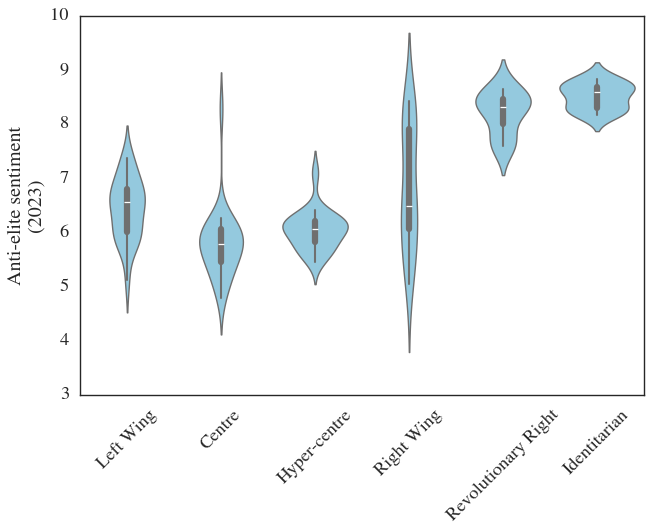

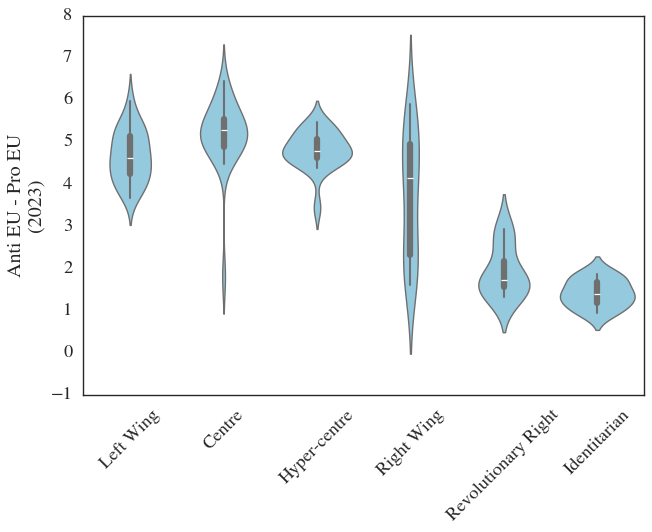

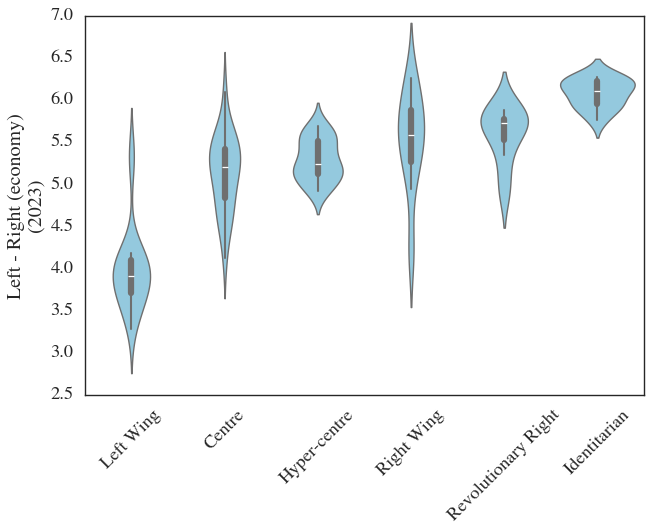

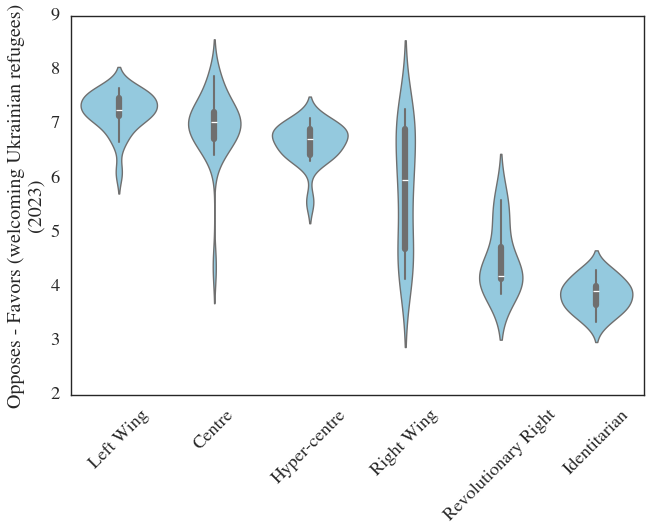

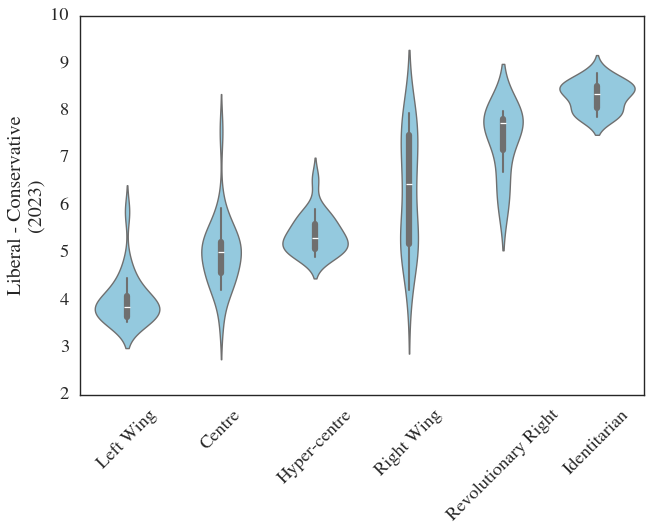

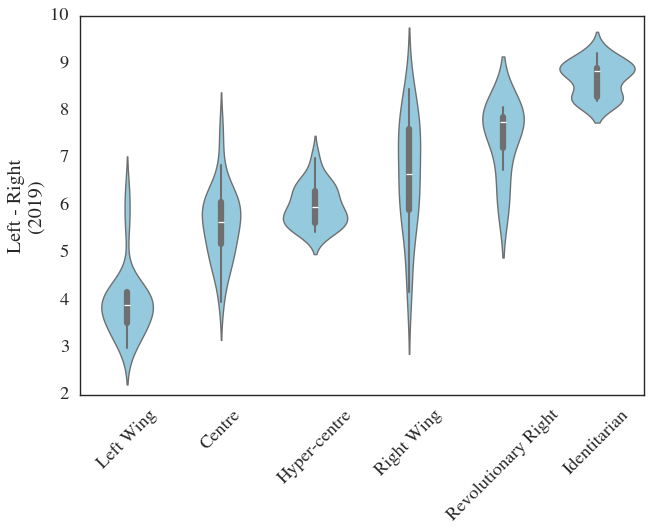

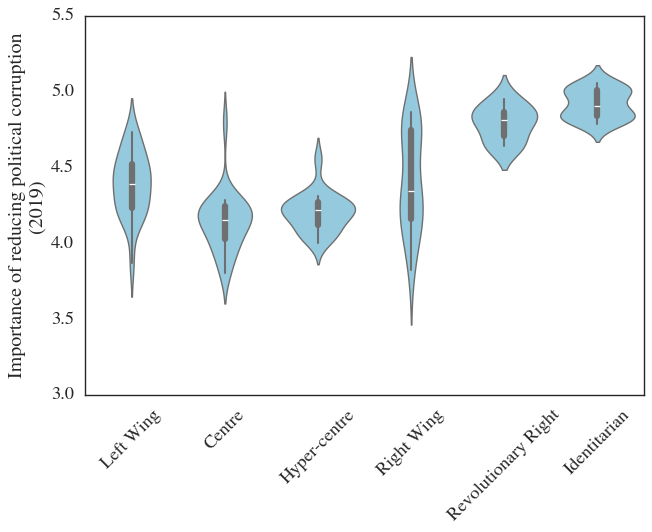

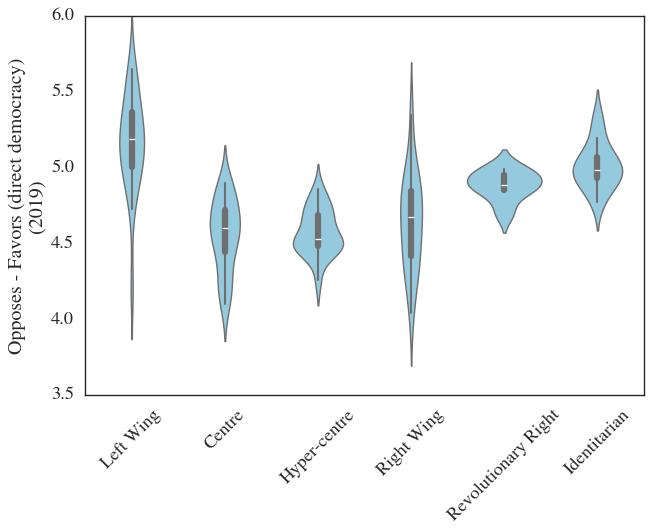

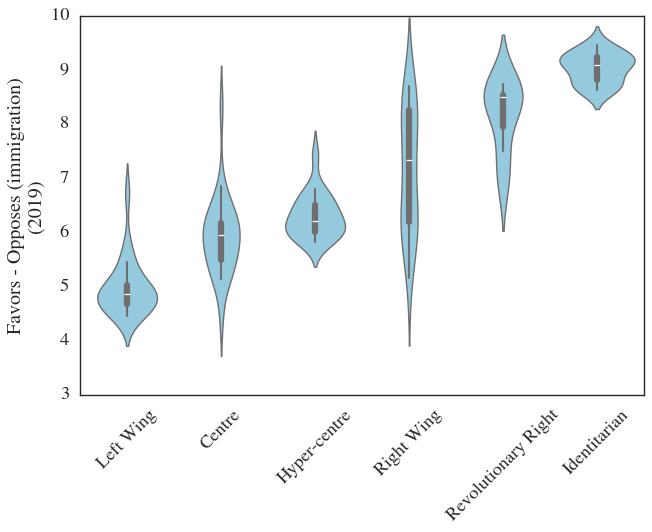

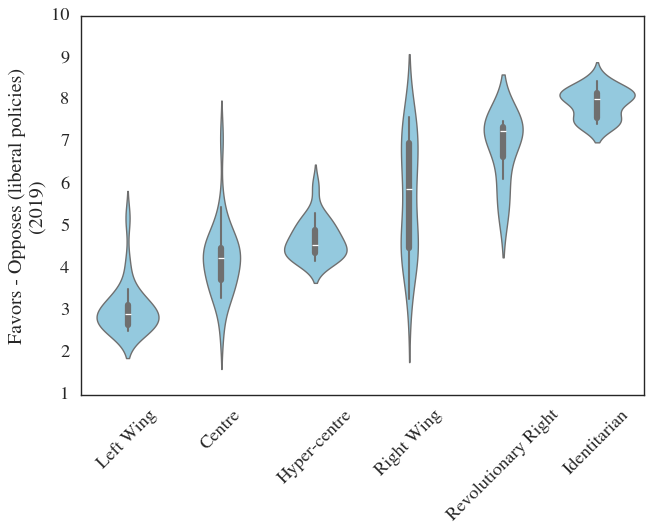

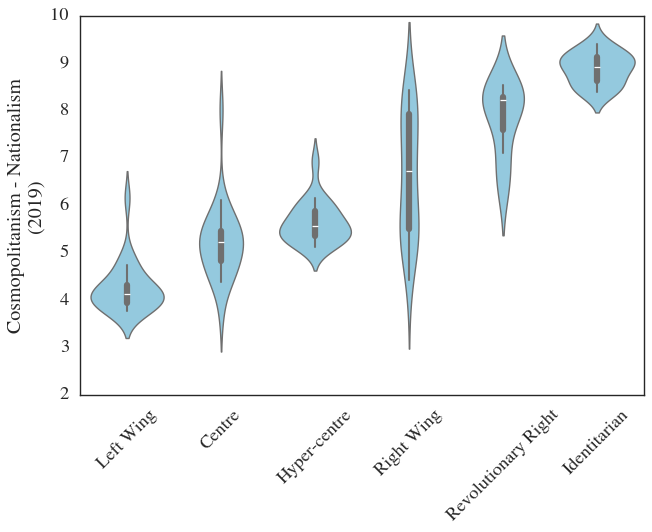

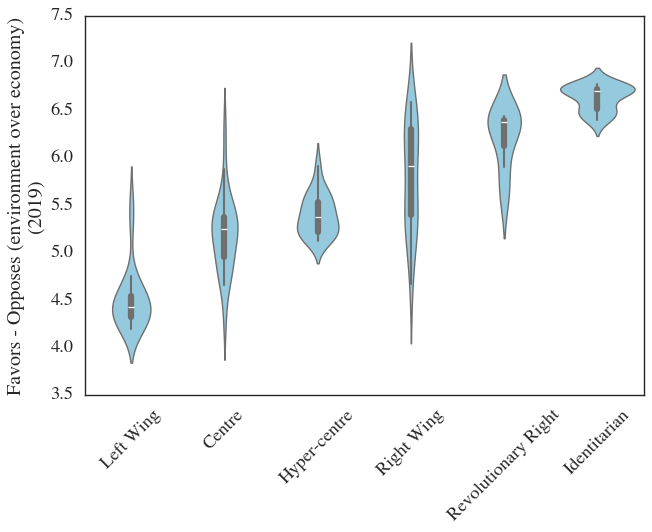

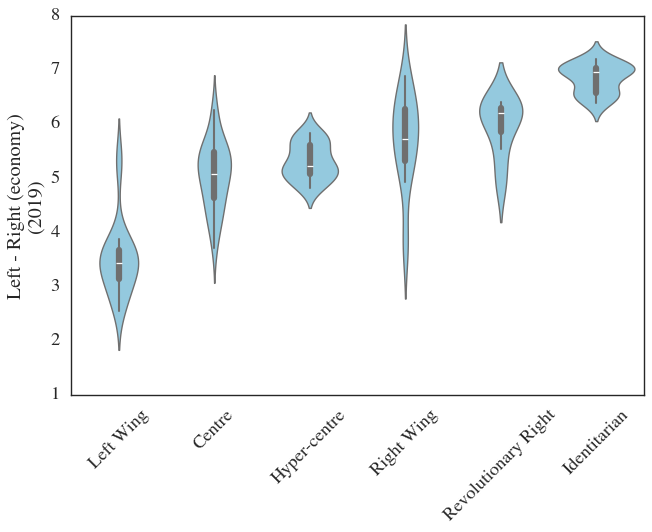

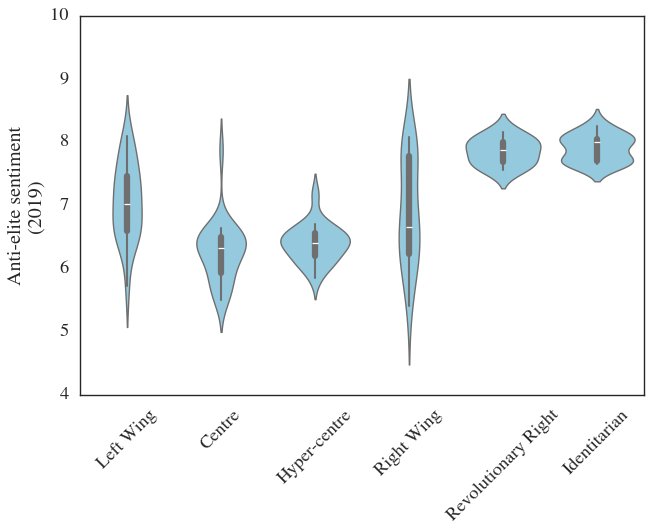

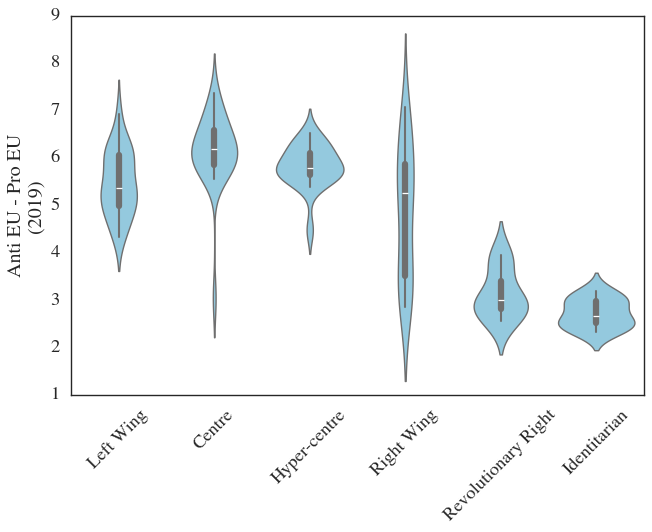

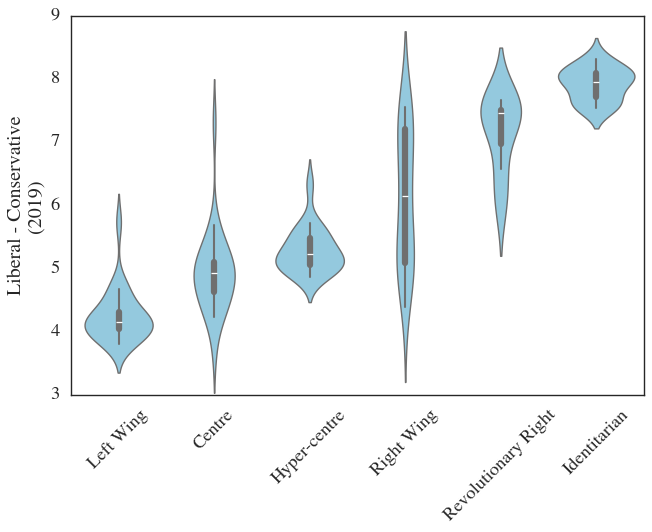

In [65]:
# formatting
color = plt.get_cmap('magma_r')
sns.set_theme(style="white", font='STIXGeneral', font_scale=1.5)

# restrict to categories of interest
df_ = df_domains[df_domains['media_category'].isin(categories)]

# plot dimension by dimension
for dim in Dimensions:
    fig,ax = plt.subplots(figsize=(8,6.5))

    # violin plot
    sns.violinplot(data=df_, x='media_category', y=dim+'_mean', 
                   inner='box', order=categories, color='skyblue')

    # style
    plt.xticks(rotation = 45)
    plt.xlabel('')
    plt.ylabel(f'{dim_names[dim[:-3]]}\n(20{dim[-2:]})')
    plt.tight_layout(pad=.1)

    # save and show
    plt.savefig(fig_path + f'media_validation_{dim}.pdf')
    plt.show()
    plt.close()